In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

import torch.nn as nn
import torch.optim as optim
import torch.distributions as D
import torch.nn.functional as F
torch.autograd.set_detect_anomaly(True)

from models import vgg16, sto_vgg16
from utils import compute_accuracy, compute_ece_loss
from flows import NormalAffine, NormalGlowStep, NormalPlanar1d, NormalInvConv
from models import StoModel, sto_vgg16
from utils import train_sto_model, plot_multiple_results, plot_results, prepare_dataset

In [2]:
# setup device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True

# define data folder
data_dir = "./data"
fig_dir = "./figs"
weight_dir = "./models/trained/"

In [3]:
class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
trainloader, testloader = prepare_dataset(data_dir, "cifar10", train_bs=128, test_bs=16)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
feature_flow = [NormalAffine]*3 + [NormalInvConv] + \
                [NormalAffine]*3 + [NormalInvConv] + \
                [NormalAffine]*2 + [NormalInvConv] + [NormalAffine]*2
classifier_flow = [NormalAffine] + [NormalPlanar1d] + [NormalAffine]
sto_model_cfg = feature_flow + classifier_flow

In [5]:
sto_model:StoModel = sto_vgg16(sto_cfg=sto_model_cfg).to(device)
sto_model.load_state_dict(torch.load("{}/{}".format(weight_dir, "sto_vgg_flow.pth")))

<All keys matched successfully>

In [6]:
sto_model.eval()
sto_model.no_fixed_samples()
test_iterator = iter(testloader)

In [7]:
with torch.no_grad():
    images, labels = next(test_iterator)
    images, labels = images.to(device), labels.to(device)
    probs, variances = sto_model.make_prediction(images, n_samples=128)

In [11]:
def plot_cifar10_imgs(images, probs, variances):
    fig = plt.figure(figsize=(25,12))

    plt.subplot(1,3,1)
    comb = images.permute(0,2,3,1).flatten(0,1)
    comb = comb.detach().cpu().numpy()
    # r, c, _ = comb.shape 
    # comb = np.concatenate((comb[:r//2, :, :], comb[r//2:, :, :]), axis=1)
    comb = comb * np.array([0.2023, 0.1994, 0.2010]).reshape(1,1,3)
    comb = comb + np.array([0.4914, 0.4822, 0.4465]).reshape(1,1,3)
    plt.imshow(comb)
    plt.yticks(ticks=range(0, comb.shape[0], comb.shape[1]), labels=range(16))
    plt.xticks(ticks=[])

    plt.subplot(1,3,2)
    plt.imshow(probs.detach().cpu().numpy())
    plt.xticks(ticks=range(10),labels=list(class_names), rotation=60)
    plt.colorbar()
    plt.title("Mean Prediction Proability")

    plt.subplot(1,3,3)
    plt.imshow(variances.detach().cpu().numpy())
    plt.xticks(ticks=range(10),labels=list(class_names), rotation=60)
    plt.colorbar()
    plt.title("Prediction Variance")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


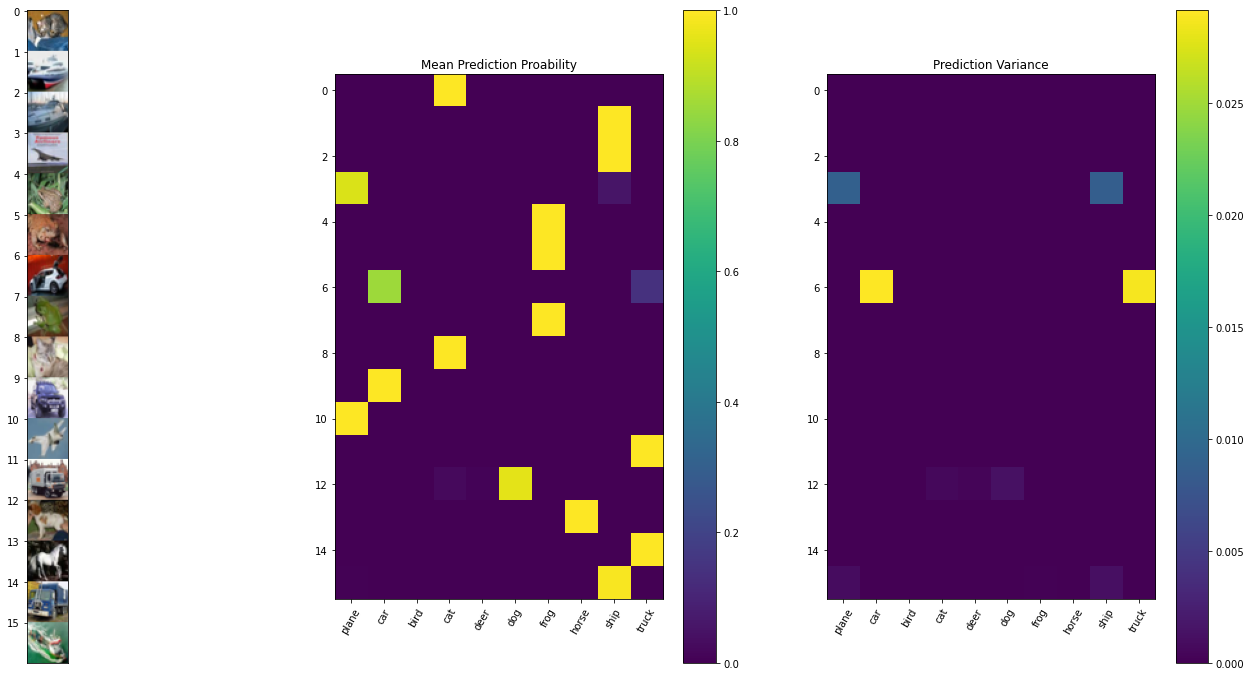

In [9]:
plot_cifar10_imgs(images, probs, variances)

In [10]:
sto_model_cfg = [NormalAffine]*16
sto_model = sto_vgg16(sto_cfg=sto_model_cfg).to(device)
sto_model.load_state_dict(torch.load("{}/{}".format(weight_dir, "sto_vgg_no_flow.pth")))

<All keys matched successfully>

In [12]:
with torch.no_grad():
    probs, variances = sto_model.make_prediction(images, n_samples=128)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


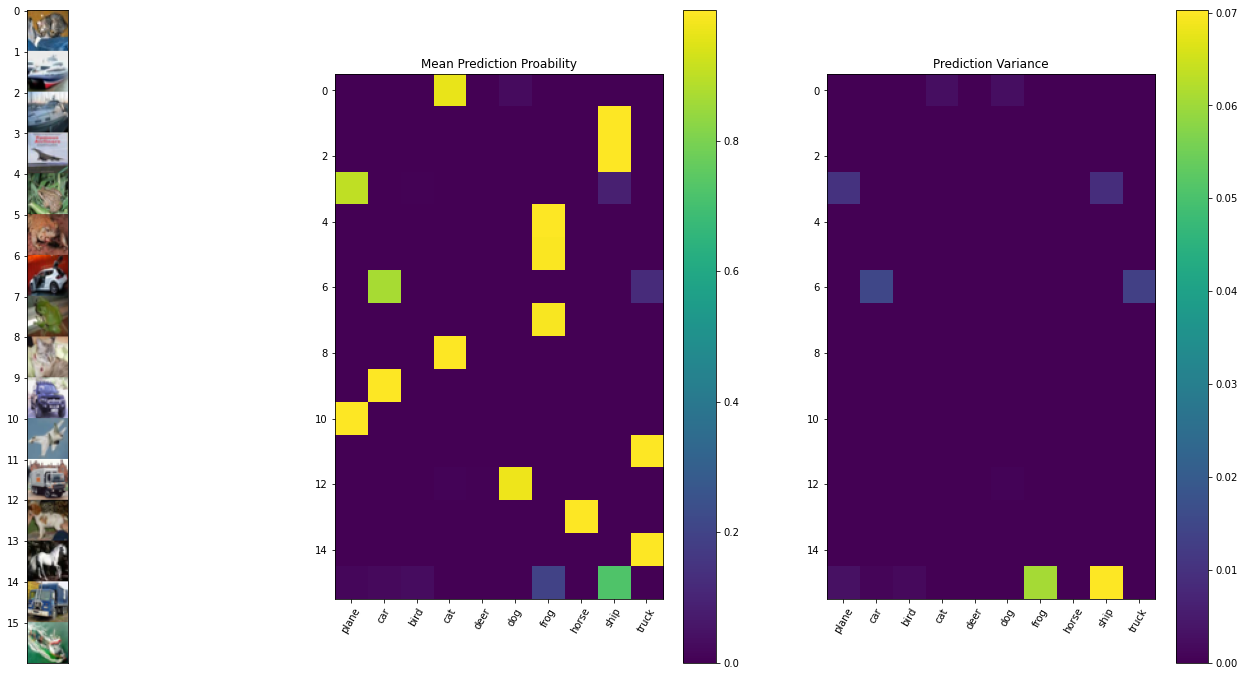

In [13]:
plot_cifar10_imgs(images, probs, variances)